Epoch 1/10
8097/8097 [==============================] - 2017s 248ms/step - loss: 0.0219


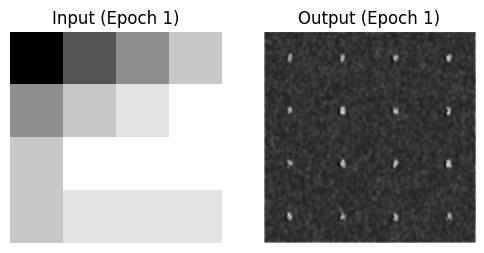

C:\Users\priya\anaconda3\envs\anacondagpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model saved at epoch 1
Epoch 2/10
8097/8097 [==============================] - 2003s 247ms/step - loss: 0.0028


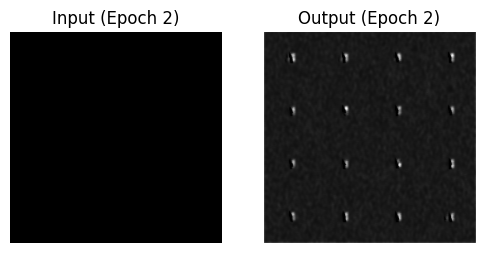

Model saved at epoch 2
Epoch 3/10
8097/8097 [==============================] - 2005s 248ms/step - loss: 0.0025


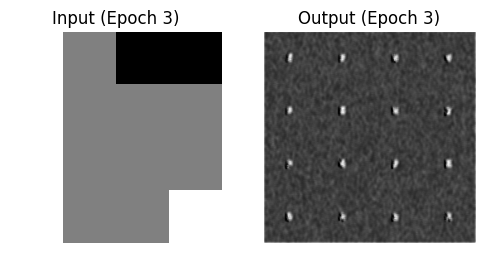

Model saved at epoch 3
Epoch 4/10
8097/8097 [==============================] - 2005s 248ms/step - loss: 0.0023


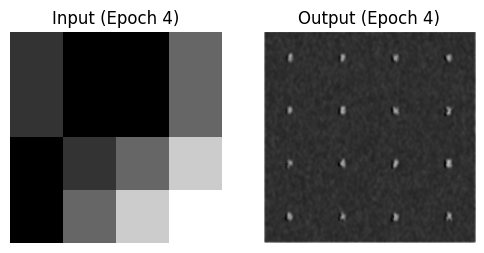

Model saved at epoch 4
Epoch 5/10
8097/8097 [==============================] - 2004s 248ms/step - loss: 0.0022


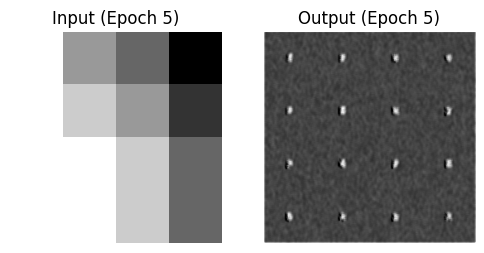

Model saved at epoch 5
Epoch 6/10
8097/8097 [==============================] - 2004s 248ms/step - loss: 0.0021


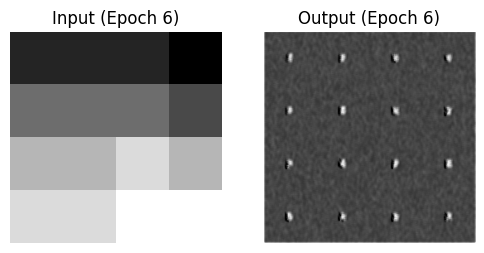

Model saved at epoch 6
Epoch 7/10
8097/8097 [==============================] - 2005s 248ms/step - loss: 0.0020


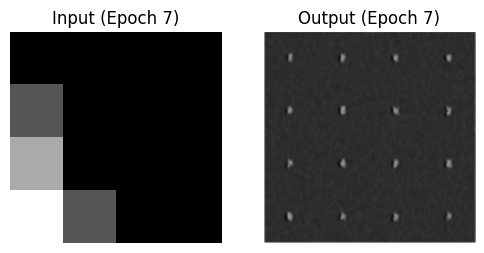

Model saved at epoch 7
Epoch 8/10
8097/8097 [==============================] - 2004s 248ms/step - loss: 0.0020


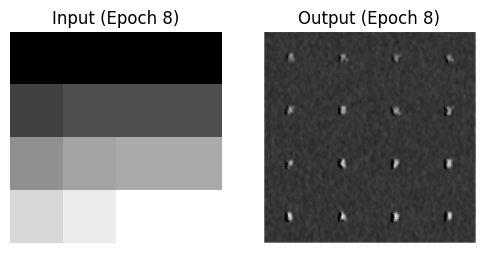

Model saved at epoch 8
Epoch 9/10
8097/8097 [==============================] - 2003s 247ms/step - loss: 0.0016


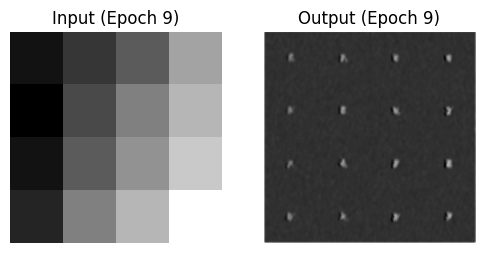

Model saved at epoch 9
Epoch 10/10
8097/8097 [==============================] - 2004s 248ms/step - loss: 0.0015


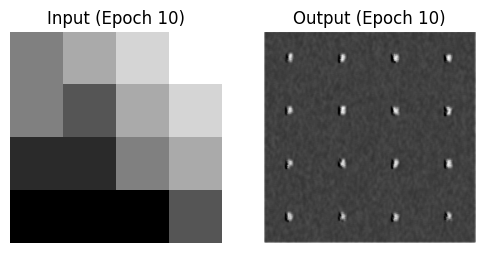

Model saved at epoch 10


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.feature_extraction import image
import cv2

# Load and preprocess the 512x512 brain image
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (512, 512))  # Ensure image is 512x512
    img = img.astype(np.float32) / 255.0  # Normalize to [0,1] range
    
    #img = tf.io.read_file(image_path)
    #img = tf.image.decode_png(img, channels=1)  # Assuming grayscale image
    #img = tf.image.resize(img, [512, 512])
    #img = img / 255.0  # Normalize to [0,1]
    #return np.expand_dims(img, axis=0)
    return img

# Extract 5x5 patches (windows) from the 512x512 image
def extract_windows(img, window_size=4):
    patches = image.extract_patches_2d(img, (window_size, window_size))
    patches = patches.reshape((-1, window_size, window_size, 1))  # Add channel dimension
    return patches

# Define the attention mechanism
def attention_block(x, filters):
    g1 = layers.Conv2D(filters, (1, 1))(x)
    x1 = layers.Conv2D(filters, (1, 1))(x)
    psi = layers.Conv2D(1, (1, 1), activation='sigmoid')(layers.Add()([g1, x1]))
    return layers.Multiply()([x, psi])

# Define the Encoder
def encoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = attention_block(x, 128)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    latent = layers.Dense(64, activation='relu')(x)
    return models.Model(inputs, latent)

# Define the Decoder
def decoder(latent_shape):
    latent_inputs = layers.Input(shape=latent_shape)
    x = layers.Dense(256 * 256, activation='relu')(latent_inputs)
    x = layers.Reshape((256, 256, 1))(x)
    x = layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid')(x)
    return models.Model(latent_inputs, x)

# Define the full autoencoder model
def autoencoder(input_shape):
    enc = encoder(input_shape)
    dec = decoder((64,))
    
    inputs = layers.Input(shape=input_shape)
    latent = enc(inputs)
    reconstructed = dec(latent)
    
    return models.Model(inputs, reconstructed)

# Loss function combining SSIM and MSE
import tensorflow as tf

def combined_loss(y_true, y_pred):
    # Resize y_pred to match y_true if needed
    y_pred_resized = tf.image.resize(y_pred, tf.shape(y_true)[1:3])
    
    # Calculate SSIM loss with custom filter size for smaller window
    ssim_loss = 1 - tf.image.ssim(y_true, y_pred_resized, max_val=1.0, filter_size=4)
    
    # MSE Loss
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred_resized))
    
    # Combined loss
    return 0 * mse_loss + 1 * ssim_loss




# Load the image and preprocess it
image_path = r'61_processed_image_edit.png'  # Replace with the path to your image
img = load_and_preprocess_image(image_path)

# Extract 5x5 windows
train_windows = extract_windows(img, window_size=4)

# Define input shape and initialize the model
input_shape = (4, 4, 1)  # 5x5 windows, single channel
model = autoencoder(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=combined_loss)

# Training the model for 1000 epochs per window
epochs_per_window = 10
save_interval = 1  # Save the model every 100 epochs
print_interval = 1  # Print input and output every 50 epochs

# Function to visualize the input and output
def plot_input_output(input_img, output_img, epoch):
    plt.figure(figsize=(6, 3))

    # Display input image
    plt.subplot(1, 2, 1)
    plt.title(f"Input (Epoch {epoch})")
    plt.imshow(input_img.squeeze(), cmap='gray')
    plt.axis('off')

    # Display output image
    plt.subplot(1, 2, 2)
    plt.title(f"Output (Epoch {epoch})")
    plt.imshow(output_img.squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()

# Training loop with periodic model saving and output display
for epoch in range(epochs_per_window):
    print(f"Epoch {epoch+1}/{epochs_per_window}")
    model.fit(train_windows, train_windows, epochs=1, batch_size=32)

    # Every 50 epochs, display the input and model's output
    if (epoch + 1) % print_interval == 0:
        random_window = train_windows[np.random.randint(0, len(train_windows))]  # Pick a random window
        output = model.predict(random_window[np.newaxis, ...])  # Get model output
        plot_input_output(random_window, output, epoch + 1)

    # Every 100 epochs, save the model
    if (epoch + 1) % save_interval == 0:
        model.save(f'autoencoder_model_epoch_{epoch+1}.h5')
        print(f"Model saved at epoch {epoch+1}")



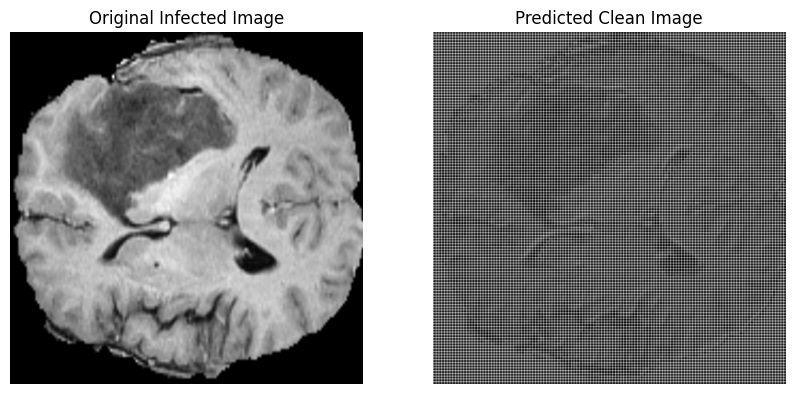

In [2]:
import numpy as np
import cv2
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model(r"C:\Users\priya\Documents\DL project\autoencoder_model_epoch_5.h5", custom_objects={'combined_loss': combined_loss})

# Set the test image directory and image dimensions
test_image_dir = 'test'
image_size = 512
window_size = 4
stride = window_size  # Non-overlapping windows

# Load and preprocess the test image
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_size, image_size))  # Ensure it's 512x512
    img = img.astype('float32') / 255.0  # Normalize the image
    return img

# Process the image in windows and reconstruct the predicted clean image
def reconstruct_clean_image(test_image):
    output_window_size = 256  # Model output size (adjust this based on your model)
    reconstructed_image = np.zeros_like(test_image)
    count_matrix = np.zeros_like(test_image)

    for i in range(0, image_size - window_size + 1, stride):
        for j in range(0, image_size - window_size + 1, stride):
            # Extract the window from the test image
            window = test_image[i:i+window_size, j:j+window_size]
            window = np.expand_dims(window, axis=(0, -1))  # Add batch and channel dimensions

            # Predict the clean window using the model
            predicted_window = model.predict(window)
            predicted_window = np.squeeze(predicted_window)  # Remove batch and channel dimensions

            # Since the predicted window is larger, extract only the relevant 5x5 region
            predicted_window_cropped = predicted_window[0:window_size, 0:window_size]

            # Insert the cropped predicted window back into the reconstructed image
            reconstructed_image[i:i+window_size, j:j+window_size] += predicted_window_cropped
            count_matrix[i:i+window_size, j:j+window_size] += 1

    # Average out the overlapping regions if any
    reconstructed_image /= np.maximum(count_matrix, 1)
    return reconstructed_image



# Display the original and predicted images
def display_images(original_image, predicted_image):
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.title('Original Infected Image')
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    # Predicted clean image
    plt.subplot(1, 2, 2)
    plt.title('Predicted Clean Image')
    plt.imshow(predicted_image, cmap='gray')
    plt.axis('off')

    plt.show()

# Main function to test the model
def test_model_on_image():
    # Load the test image
    test_image_path = os.path.join(test_image_dir, 'processed_image_edit.png')  # Update with the actual test image filename
    test_image = load_and_preprocess_image(test_image_path)

    # Reconstruct the clean image using the model
    predicted_clean_image = reconstruct_clean_image(test_image)

    # Display the original and predicted images
    display_images(test_image, predicted_clean_image)
    return predicted_clean_image

# Run the test
predicted__image=test_model_on_image()
